# Dataset Description : Electrical Grid Stability Simulated Data
## Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy sources, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

## Attribute information: 
### 11 predictive attributes, 1 non-predictive(p1), 2 goal fields:
### 1. tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
###  2. p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
### 3. g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
### 4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
### 5. stabf: the stability label of the system (categorical: stable/unstable)

### Predictive features:

### 'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
### 'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
### 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');
### Dependent variables:

### 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
### 'stabf': a categorical (binary) label ('stable' or 'unstable').
### Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).

### Split the data into an 80-20 train-test split with a random state of “1”. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test). Use scikit learn to train a random forest and extra trees classifier. And use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model. Use random_state = 1 for training all models and evaluate on the test set. Answer the following questions:

# Questions 
## Question 1: What is the accuracy on the test set using the random forest classifier? In 4 decimal places.
## Question 2: What is the accuracy on the test set using the XGboost classifier? In 4 decimal places.
## Question 3: What is the accuracy on the test set using the LGBM classifier? In 4 decimal places.
## Question 4: Using the ExtraTreesClassifier as your estimator with cv=5, n_iter=10, scoring = 'accuracy', n_jobs = -1, verbose = 1 and random_state = 1. What are the best hyperparameters from the randomized search CV?
## Question 5: Train a new ExtraTreesClassifier Model with the new Hyperparameters from the RandomizedSearchCV (with random_state = 1). Is the accuracy of the new optimal model higher or lower than the initial ExtraTreesClassifier model with no hyperparameter tuning?
## Question 6: Find the feature importance using the optimal ExtraTreesClassifier model. Which features are the most and least important respectively?

## Now let's start by loading our librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler             
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix 

# Let's load our dataset and look his characteristics

In [2]:
df= pd.read_csv("Data_for_UCI_named.csv", encoding='ISO-8859-1')

In [3]:
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


#### We have two dependent variables which are 'stab' and 'stabf', i will drop 'stab', so we can to our binary classififcation properly

In [7]:
df = df.drop('stab', axis =1)

In [8]:
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,unstable


### Before answering my questions, i wull first split the dataset (df)

In [9]:
#Let define our labels and features variables
x = df.drop(columns=['stabf'])

y = df['stabf']

In [10]:
#Split the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print('X_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (8000, 12)
y_train shape: (8000,)
X_test shape: (2000, 12)
y_test shape: (2000,)


In [11]:
#Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test)
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test) 

x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns)

## Time to answers our questions 

### Question 1:

In [12]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(random_state=1)

#Train the model 
clf.fit(x_train_scaled, y_train)

y_pred=clf.predict(x_test_scaled)

In [13]:
from sklearn import metrics

acc = accuracy_score(y_pred, y_test)

print("Accuracy:",round(acc,4))

Accuracy: 0.929


#### Answer: 0.929

### Question 3:

In [14]:
lgbm= LGBMClassifier(random_state = 1)

#fit on train set
lgbm.fit(x_train_scaled, y_train)

#predict on test set
lgbm_pred = lgbm.predict(x_test_scaled)

In [15]:
accuracy = accuracy_score(y_test, lgbm_pred)
print("The LightGBM test set accuracy is:  ", round(accuracy, 4))

The LightGBM test set accuracy is:   0.9395


#### Answer: 0.9395

### Question 4: 

In [16]:
#Define Extra Trees Classifier model
extra_tree = ExtraTreesClassifier(random_state = 1)

#Parameters to try
param = {'n_estimators': [50, 100, 300, 500, 1000], 
         'min_samples_split': [2, 3, 5, 7, 9], 
         'min_samples_leaf': [1, 2, 4, 6, 8],
         'max_features': ['sqrt', 'log2', 'auto', None]    
         }

Random_Search = RandomizedSearchCV(estimator = extra_tree, param_distributions= param , random_state = 1, n_iter=10, cv=5, scoring="accuracy",
                                   n_jobs = -1, verbose = 1)

In [17]:
#Fit the model
search = Random_Search.fit(x_train_scaled, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [18]:
#get best parameters
search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': None}

#### Answer: 'n_estimators':1000; 'min_samples_split': 2;'min_samples_leaf': 8; 'max_features': None 

### Question 5:

In [19]:
# Extratree without new Hyperparameters from the RandomizedSearchCV
extra_tree1 = ExtraTreesClassifier(random_state = 1)

#fit on the train set
extra_tree1.fit(x_train_scaled, y_train)

#predict on test set
extratree1_pred = extra_tree1.predict(x_test_scaled)     

In [20]:
acc1 = accuracy_score(extratree1_pred, y_test)
print(round(acc1,4))

0.928


In [21]:
# Extratree with new Hyperparameters from the RandomizedSearchCV
extra_tree2 = ExtraTreesClassifier(max_features = None, 
                            min_samples_leaf= 8,
                            min_samples_split= 2,
                            n_estimators= 1000, 
                            random_state = 1)

#fit on train set
extra_tree2.fit(x_train_scaled, y_train)

#predict on test set
extratree2_pred = extra_tree2.predict(x_test_scaled)

In [22]:
acc2 = accuracy_score(extratree2_pred, y_test)
print(round(acc2,4))

0.927


#### Answer: the accuracy with new Hyperparameters from the RandomizedSearchCV LOWER than the one without hyperparameters

### Question 6: 

In [23]:
#Define Extra Trees Classifier model
etc = ExtraTreesClassifier(random_state = 1)
etc.fit(x_train_scaled, y_train)

feature_importance = pd.Series(etc.feature_importances_, index = x.columns)

In [24]:
feature_importance

tau1    0.117397
tau2    0.118445
tau3    0.113169
tau4    0.115466
p1      0.039507
p2      0.040371
p3      0.040706
p4      0.040579
g1      0.089783
g2      0.093676
g3      0.096883
g4      0.094019
dtype: float64

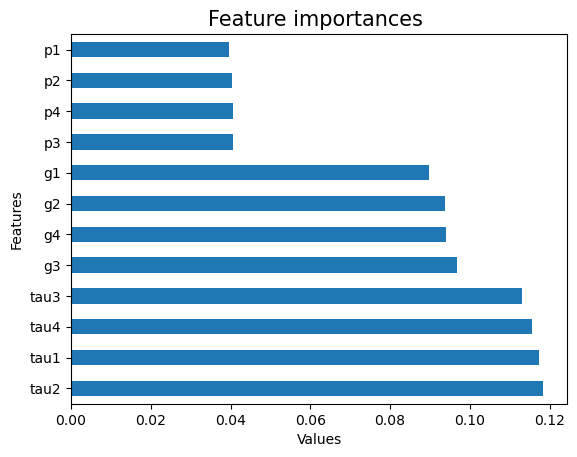

In [25]:
feature_importance.nlargest(40).plot(kind='barh')
plt.title('Feature importances ', size=15)
plt.ylabel('Features')
plt.xlabel('Values')
plt.show()

#### Answer: tau2,p1

### Question 2: 

In [29]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)

In [30]:
from xgboost import XGBClassifier

xbc= XGBClassifier(random_state = 1)

#fit on train set
xbc.fit(x_train_scaled, y_train)
#predict on test set
xbc_pred = xbc.predict(x_test_scaled)

In [32]:
xbc_accuracy = accuracy_score(y_test, xbc_pred)

print("The XGboost test set accuracy is:  ", round(xbc_accuracy, 4))

The XGboost test set accuracy is:   0.9455
